# Part 1

# Logistic Regression
In logistic regression we perform binary classification of by learnig a function of the form $f_w(x) = \sigma(x^\top w)$. Here $x,w \in \mathbb{R}^D$, where $D$ is the number of features as before. $\sigma(z) = \frac{1}{1+e^{-z}}$ is the logistic function.  Let's plot this function below

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
from itertools import permutations
warnings.filterwarnings('ignore')

Text(0.5, 1.0, 'logistic function')

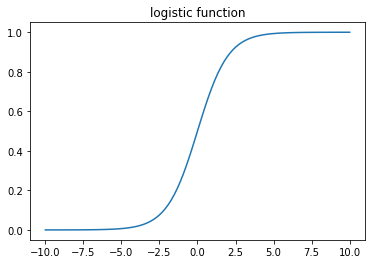

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')

## Cost function
To fit our model $f_w$ to the data $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, we maximize the **logarithm of the conditional likelihood**:

$$
\ell(w; \mathcal{D}) = \sum_n \log \mathrm{Bernoulli}(y^{(n)} | \sigma({x^{(n)}}^\top w)) = \sum_n y^{(n)} \log \sigma({x^{(n)}}^\top w)) + (1-y^{(n)}) \log (1-\sigma({x^{(n)}}^\top w)))
$$

by substituting the definition of logistic function in the equation above, and minimizing the **negative** of the log-likelihood, which is called the **cost function**,
we get

$$
J(w) = \sum_n y^{(n)} \log(1+e^{-x w^\top}) + (1-y^{(n)}) \log(1+e^{x w^\top})
$$

In practice we use mean rather than sum over data points.

In [ ]:
def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [ ]:
def accuracy(y_pred, y_true):
  """
  Returns the percentage of correctly classified test/train/validation data points.
  """
  return np.mean(1 - np.abs(y_pred - y_true))
  


## Logistic regression class
Now we are ready to implement the logistic regression class with the usual `fit` and `predict` methods. Here, the `fit` method implements gradient descent.

In [ ]:
class LogisticRegression:
    
    def __init__(self, add_bias=True, batch_size=None, learning_rate=.1, epsilon=1e-4, max_epochs=1e5, verbose=False, momentum_coeff=None, test_step_size=0):
        self.add_bias = add_bias
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        # maximum number of epochs of gradient descent. 
        # For GD it Epoch = number of iterations, but for SGD, Epoch = iterations / batch size
        self.max_epochs = max_epochs                    
        self.verbose = verbose
        self.g = None
        self.t = None
        self.epochs = None
        self.converged_norm = True
        self.momentum_coeff = momentum_coeff
        self.test_step_size = test_step_size
        
        if test_step_size != 0:
          self.train_accuracies = np.zeros(self.max_epochs // self.test_step_size)
          self.valid_accuracies = np.zeros(self.max_epochs // self.test_step_size)
          self.index = 0

    def get_minibatches(self, X, Y):
        # shuffle X and Y before minibatching
        N = X.shape[0]
        index = np.arange(N)
        np.random.shuffle(index)
        X_shuffled = X[index]
        Y_shuffled = Y[index]

        if self.batch_size != None:
            num_sections = N // self.batch_size
            remainder = N % self.batch_size
            if remainder == 0:
                xbatches = list(np.split(X_shuffled, num_sections))
                ybatches = list(np.split(Y_shuffled, num_sections))
            else:
                xbatches = list(np.split(X_shuffled[:-remainder], num_sections)) + [X_shuffled[-remainder:]]
                ybatches = list(np.split(Y_shuffled[:-remainder], num_sections)) + [Y_shuffled[-remainder:]]
        
        return xbatches, ybatches

    def momentum_update(self):
      running_average = self.momentum_coeff * self.previous_average + (1 - self.momentum_coeff) * self.g
      self.w = self.w - self.learning_rate*running_average
      self.previous_average = running_average

    def test(self):
      if self.epochs % self.test_step_size == 0:
        #print("Epoch: ", self.epochs)
        self.train_accuracies[self.index] = accuracy(self.predict(train_df.drop(['Outcome'], axis=1)), train_df['Outcome'])
        self.valid_accuracies[self.index] = accuracy(self.predict(valid_df.drop(['Outcome'], axis=1)), valid_df['Outcome'])
        self.index += 1

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        self.g = np.inf 
        self.t = 0
        
        self.epochs = 0

        # momentum
        self.previous_average = self.w
        # Mini Batch
        if self.batch_size != None:
            xbatches, ybatches = self.get_minibatches(x, y)
        batch_counter = 0
        while np.linalg.norm(self.g) > self.epsilon:
            # so we can tell why it converged
            if self.epochs == self.max_epochs:
              self.converged_norm = False
              break

            # Mini batch
            if self.batch_size != None:
                xbatch = xbatches[batch_counter]
                ybatch = ybatches[batch_counter]
                batch_counter = (batch_counter + 1) % len(xbatches)
                if batch_counter == 0:
                    # Run test
                    if self.test_step_size != 0 :
                      self.test()
                      
                    self.epochs += 1
                    # new epoch -> reshuffle the batches
                    xbatches, ybatches = self.get_minibatches(x, y)
                    
                    
                self.g = self.gradient(xbatch, ybatch)
                self.t += 1

                # momentum
                if self.momentum_coeff != None: 
                  self.momentum_update()
                else:
                  self.w = self.w - self.learning_rate * self.g
            
            else: # regular gradient descent
              self.g = self.gradient(x, y)
              self.t += 1
              self.epochs += 1

              # momentum
              if self.momentum_coeff != None: 
                  self.momentum_update()
              else:
                  self.w = self.w - self.learning_rate * self.g
            
              # Run test
              if self.test_step_size != 0 :
                self.test()

        if self.epochs == 0:
          if self.test_step_size != 0 :
              self.test()
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

In [ ]:
# Import the data
"""
We assume the data is in the same folder as the notebook and is accesible by
the path ./data.csv
"""
train_df = pd.read_csv('diabetes_train.csv')
valid_df = pd.read_csv('diabetes_val.csv')
test_df = pd.read_csv('diabetes_test.csv')

# 1

You should first start by running the logistic regression code using the given implementation. This will serve as a baseline for the following steps. Find a learning rate and a number of training iterations such that the model has fully converged to a solution. Make sure to provide empirical evidence supporting your decision (e.g. training and validation accuracy as a function of number of training iterations).


In [ ]:
"""
TASK
_____

The goal here is to simply prove that with a certain learning rate, and
number of iterations, the model will converge.

In the class slack app, it was said we only need to choose 1 learning rate and that
we should run it to convergence.

Convergence in this case can mean norm of gradient is ~0. Or we can simply show
that an increasing number of epochs does not improve the accuracy on the validation set.

To show this, we can produce 1 graph with accuracy as y axis and number 
of iterations (epochs) on x axis and show 2 lines (one for training and one for validation).

Explore different learning rates.

Finally run the model on the TEST SET and this will be the baseline accuracy.
"""


LearningRate:  1e-06

LearningRate:  1e-05

LearningRate:  0.0001

LearningRate:  0.001

LearningRate:  0.01

LearningRate:  0.1

LearningRate:  1

LearningRate:  4
Max val score: 0.63 with max epoch set to 34000 and learning rate 4




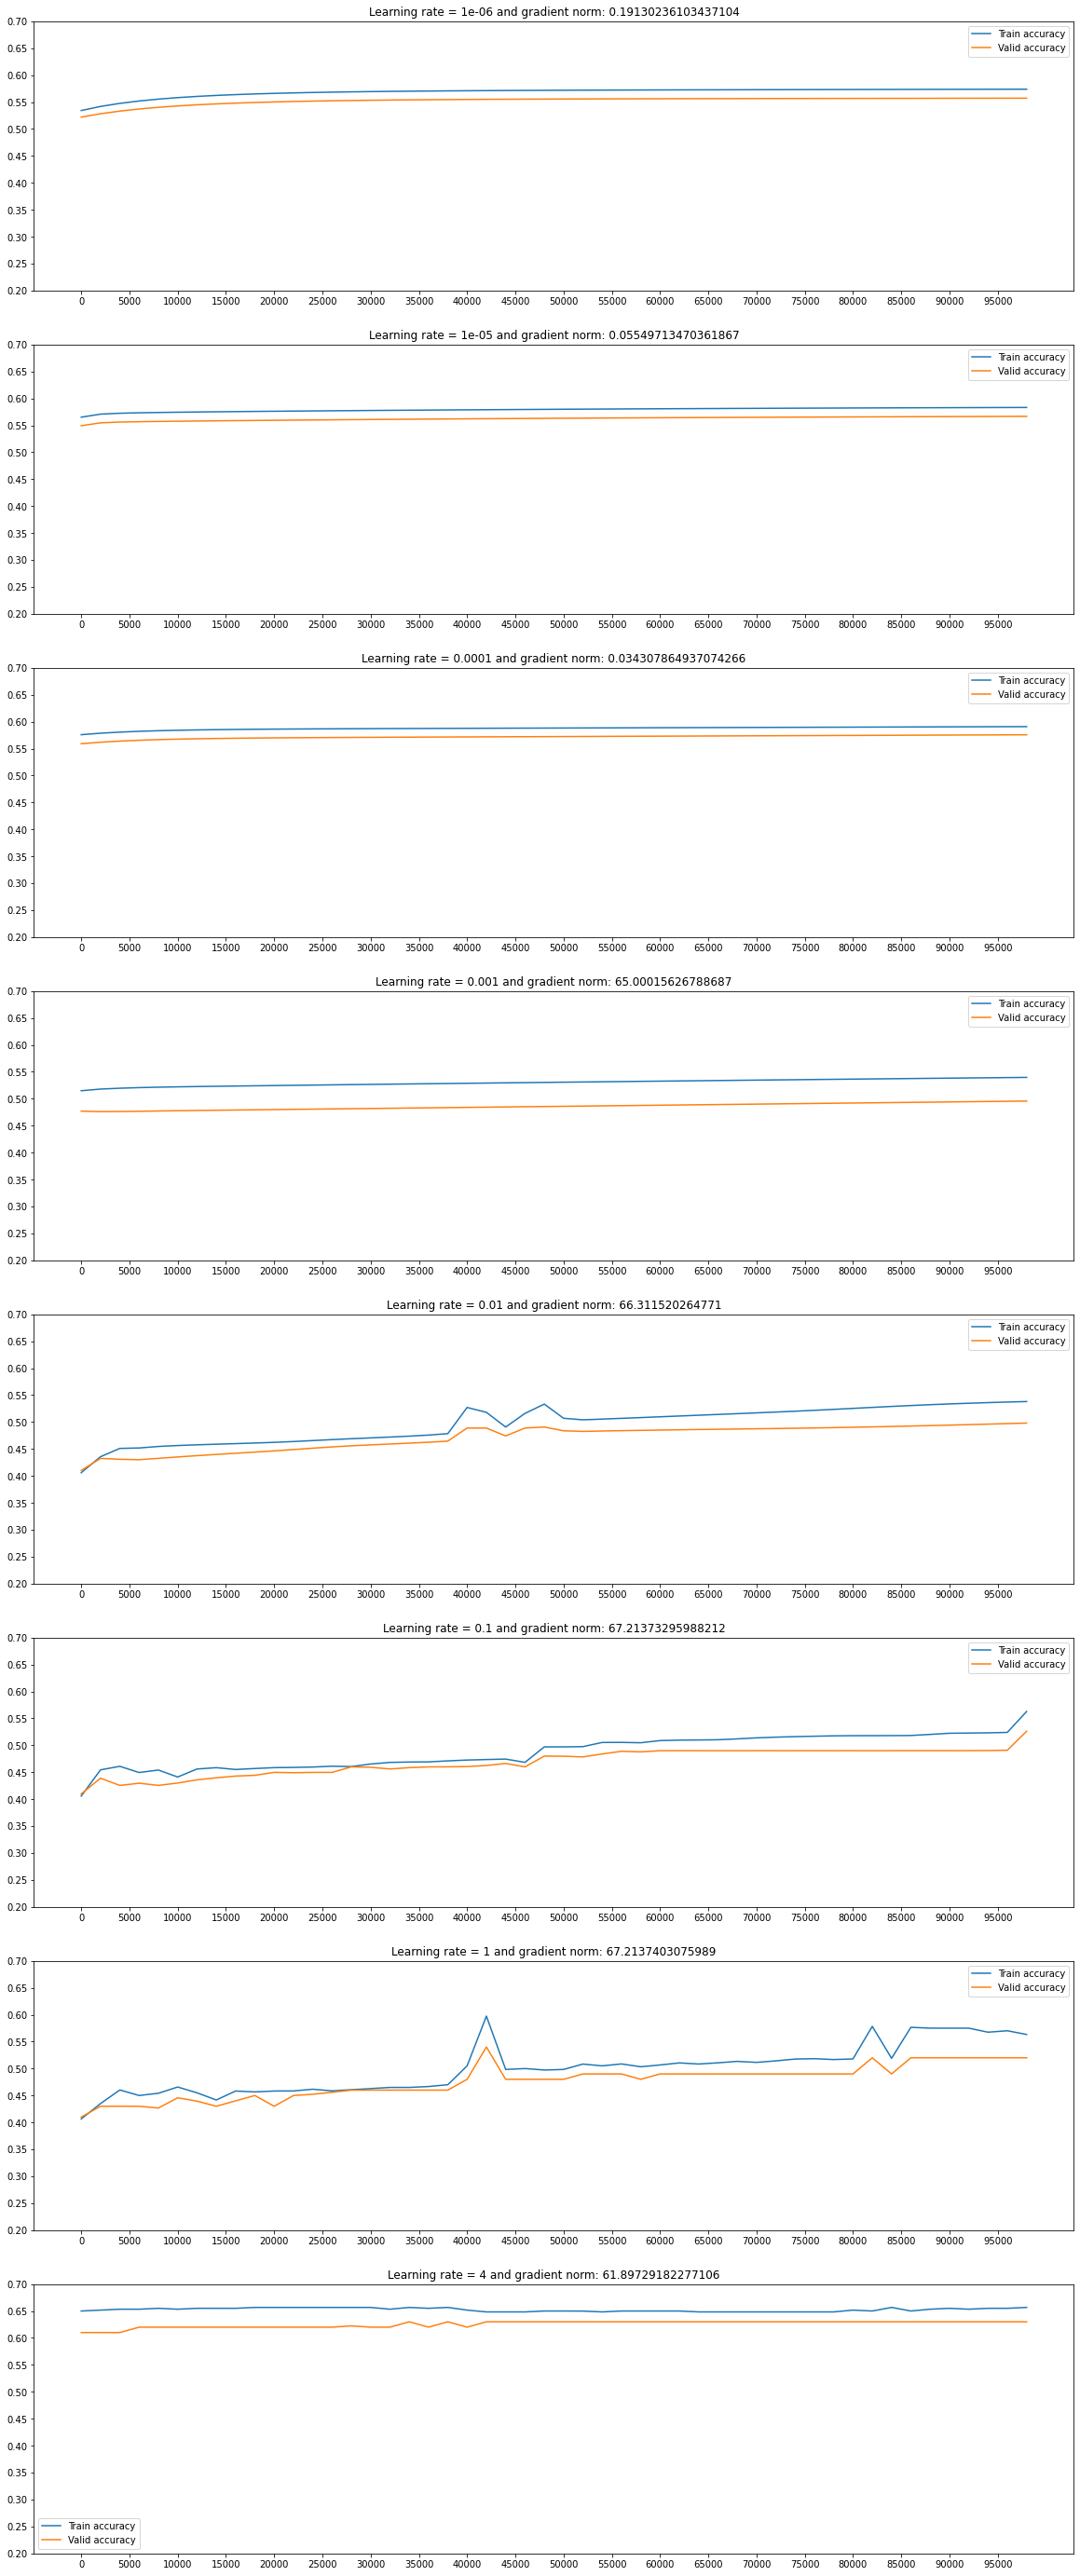

In [ ]:
"""
This code block is simply exploring learning rates in an attempt to find the one
that gives the best accuracy.

After experimentation with many learning rates and iterations it is shown that
learning rate 4 and max iteration number 300 gives the highest accuracy on the
validation set. 

FOR TA: The graphs produced are not meant to be viewed, this is simply an
explanation as to why we chose our learning rate.

Could this be convergence? Let us see...
"""
test_step_size = 2000
max_epoch = 100000
iterations = np.arange(0, max_epoch, test_step_size)
learning_rates = [.000001, .00001, .0001, .001, .01, .1, 1, 4]

max_validation_score = 0
max_iteration_score = 0
max_learning_rate = 0

fig, axs = plt.subplots(len(learning_rates), 1, figsize=(20,50))

for ax, lr in zip(axs, learning_rates):
  print("\nLearningRate: ", lr)

  clf = LogisticRegression(max_epochs=max_epoch, learning_rate=lr, verbose=False, test_step_size=test_step_size)
  clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])


  ax.plot(iterations, clf.train_accuracies, label='Train accuracy')
  ax.plot(iterations, clf.valid_accuracies, label='Valid accuracy')
  ax.set_xticks(np.arange(0, max_epoch, max_epoch // 20))
  ax.set_yticks(np.arange(.2, .75, 0.05))
  ax.set_title(f'Learning rate = {lr} and gradient norm: {np.linalg.norm(clf.g)}')
  ax.legend()
  ax.set_xlabel("Epochs trained on")
  ax.set_ylabel("Accuracy (%)")

  if np.max(clf.valid_accuracies) > max_validation_score:
    max_validation_score = np.max(clf.valid_accuracies)
    max_iteration_score = np.where(clf.valid_accuracies == max_validation_score)[0][0] * test_step_size
    max_learning_rate = lr

print(f'Max val score: {max_validation_score} with max epoch set to {max_iteration_score} and learning rate {max_learning_rate}\n\n')


LearningRate:  4
Max val score: 0.67 with max epoch set to 40 and learning rate 4




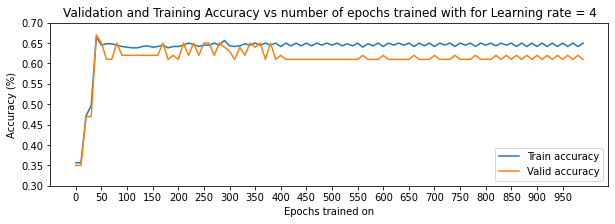

In [ ]:
"""
We know learning rate 4 has potential from the previous code block.

Let us run it untill convergence. 

From the graph we can see clearly see that running it for max epoch iterations 
from 10 - 1000 stays pretty level meaning it has converged. Iterations up to 
100,000 were performed (as shown in above cell) and the maximum accuracy found 
does not increase with more iterations. 

We see that the max value obtained was way before 1000 at around 50 but we will
consider the one at 300/400 to be ideal, since after that is when it starts decreasing.

This means it converged at 300/400 and is oscillating around this point with every 
new iteration.

"""
test_step_size = 10
max_epoch = 1000
iterations = np.arange(0, max_epoch, test_step_size)
lr = 4

max_validation_score = 0
max_iteration_score = 0
max_learning_rate = 0

fig, axs = plt.subplots(1, 1, figsize=(10,3))

print("\nLearningRate: ", lr)

clf = LogisticRegression(max_epochs=max_epoch, learning_rate=lr, verbose=False, test_step_size=test_step_size)
clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])


axs.plot(iterations, clf.train_accuracies, label='Train accuracy')
axs.plot(iterations, clf.valid_accuracies, label='Valid accuracy')
axs.set_xticks(np.arange(0, max_epoch, max_epoch // 20))
axs.set_yticks(np.arange(.3, .75, 0.05))
axs.set_xlabel("Epochs trained on")
axs.set_ylabel("Accuracy (%)")
axs.set_title(f'Validation and Training Accuracy vs number of epochs trained with for Learning rate = {lr}')
axs.legend()

if np.max(clf.valid_accuracies) > max_validation_score:
  max_validation_score = np.max(clf.valid_accuracies)
  max_iteration_score = np.where(clf.valid_accuracies == max_validation_score)[0][0] * test_step_size
  max_learning_rate = lr

print(f'Max val score: {max_validation_score} with max epoch set to {max_iteration_score} and learning rate {max_learning_rate}\n\n')

In [ ]:
"""
Now lets test on the test set, using the best hyperparameters we found:

Learning rate = 4 and max epochs = 300
"""

clf = LogisticRegression(max_epochs=300, learning_rate=4, verbose=False)
clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])

print(accuracy(clf.predict(test_df.drop(['Outcome'],axis=1)), test_df['Outcome']))


0.7058823529411765


# 2

Implement mini-batch stochastic gradient descent. Then, using growing minibatch sizes (e.g. 8, 16, 32, ...) compare the convergence speed and the quality of the final solution to the fully batched baseline. What configuration works the best among the ones you tried ?




In [ ]:
"""
Produce table of accuracies and convergence speed (number of epochs) for all
mini batch sizes (5, 8, 12, 16, 20, 25, 28, 32).
"""

In [ ]:
batch_sizes =  [None, 5, 8, 12, 16, 20, 25, 28, 32]
result_df = pd.DataFrame(index=batch_sizes, 
                         columns=['Grandient Norm', 'Iters', 'Epochs', 'Train acc', 'Val acc', 'Test acc'])
result_df.index.name = 'Batch Size'
for batch_size in batch_sizes:
    # if batch_size is None:
    #   # baseline
    #   print('Baseline results with full batch size')
    # else:
    #   print(f'Results with batch size of {batch_size}')

    clf = LogisticRegression(batch_size=batch_size, max_epochs=400, learning_rate=4, verbose=False)
    X = train_df.drop(['Outcome'],axis=1)
    Y = train_df['Outcome']
    clf.fit(X, Y)

    acc_train = accuracy(clf.predict(train_df.drop(['Outcome'],axis=1)), train_df['Outcome'])
    acc_valid = accuracy(clf.predict(valid_df.drop(['Outcome'],axis=1)), valid_df['Outcome'])
    acc_test = accuracy(clf.predict(test_df.drop(['Outcome'],axis=1)), test_df['Outcome'])

    # print(f'\n\tGradient norm: {np.linalg.norm(clf.g)}')
    # print(f'\t Number of iterations: {clf.t}')
    # print(f'\t Number of epochs: {clf.epochs}')
    # print(f'\t Train accuracy: {acc_train}')
    # print(f'\t Valid accuracy: {acc_valid}')
    # print(f'\t Test accuracy: {acc_test}\n')

    result_df.loc[batch_size] = [np.linalg.norm(clf.g), 
                                clf.t, 
                                clf.epochs, 
                                acc_train,
                                acc_valid,
                                acc_test]
result_df.to_csv('minibatch_results.csv')
result_df

,Grandient Norm,Iters,Epochs,Train acc,Val acc,Test acc
Batch Size,,,,,,
NaN,40.5518,400,400,0.65,0.61,0.676471
5,0,35,0,0.653333,0.62,0.705882
8,0,22,0,0.605,0.51,0.573529
12,0,171,3,0.653333,0.65,0.705882
16,0,1803,47,0.658333,0.61,0.676471
20,0,11832,394,0.636667,0.56,0.617647
25,53.2743,9600,400,0.651667,0.61,0.676471
28,0,814,37,0.643333,0.62,0.691176
32,19.2816,7600,400,0.668333,0.64,0.661765


# 3 
Add momentum to the gradient descent implementation. Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? Specifically, analyze the impact of momentum on the convergence speed and the quality of the final solution.

In [ ]:
"""
The goal here is to see how momentum affects accuracy and convergence speed.

We will try three different values for momentum [.9, .95, .99]

We will test this on our previous answers with learning rate of: 4 and max epoch: 200000

"""



Momentum:  0.9

LearningRate:  4

Momentum:  0.95

LearningRate:  4

Momentum:  0.99

LearningRate:  4
Max val score: 0.8111612766079566 with max epoch set to 129000 and learning rate 4




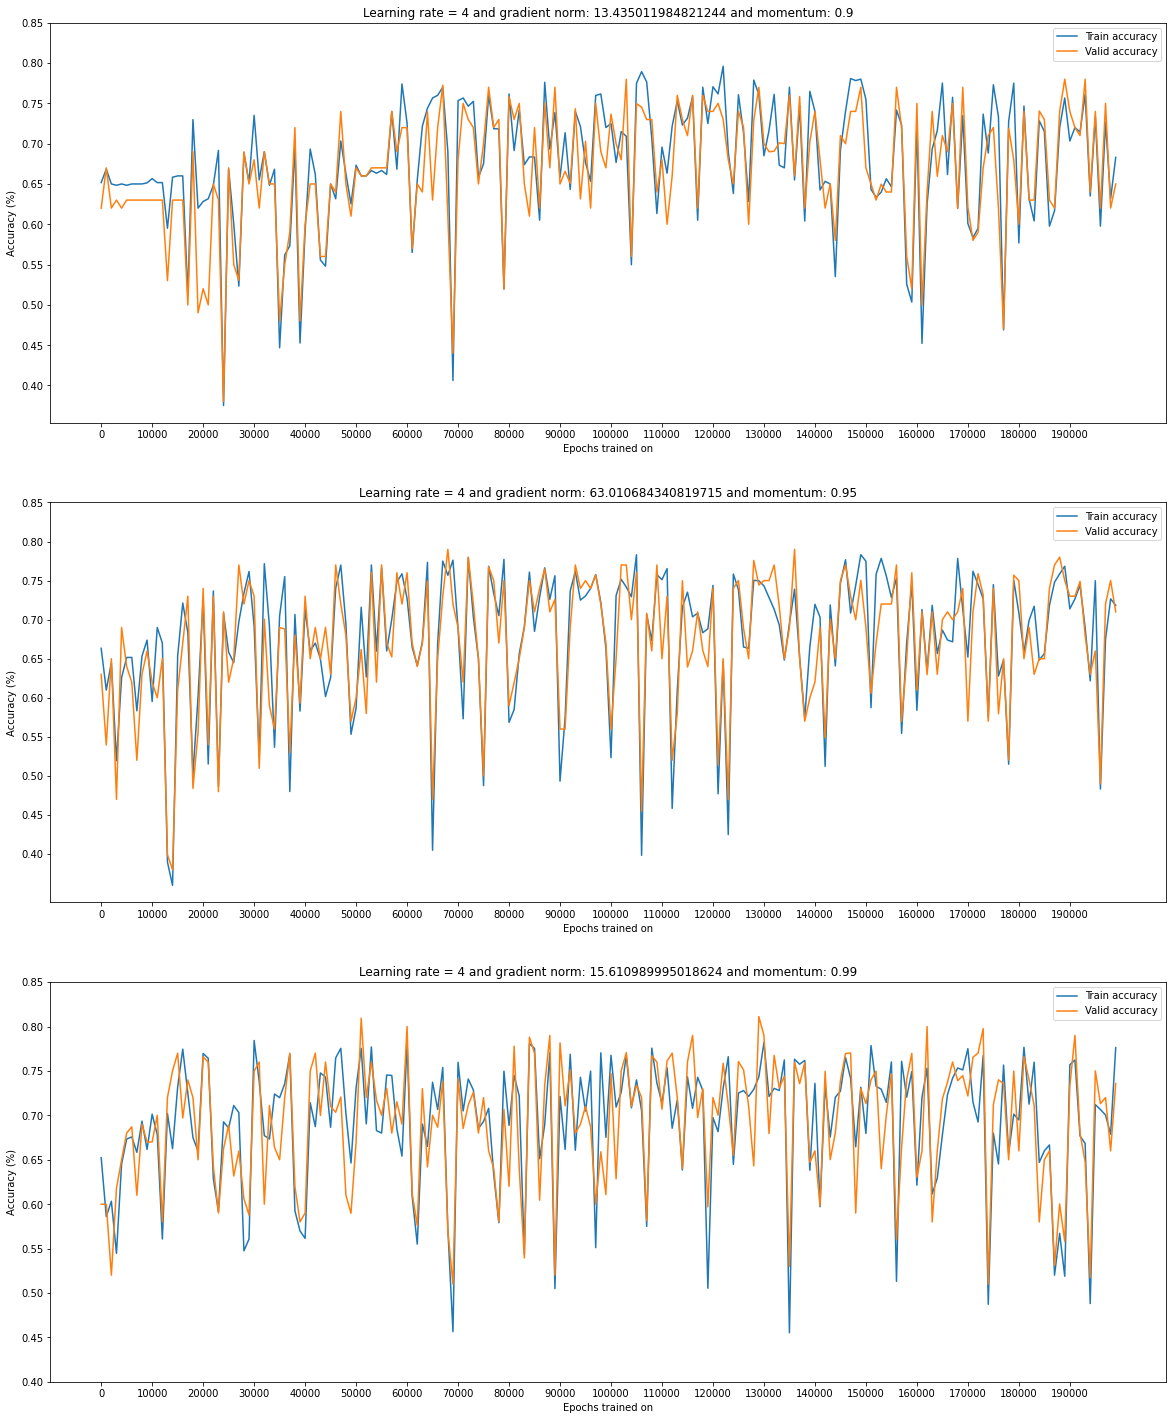

In [ ]:
"""
It was observed ealry on that momentum can increase accuray significantly (~10%)
but requires more epochs and longer convergence.

"""
test_step_size = 1000
max_epoch = 200000
iterations = np.arange(0, max_epoch, test_step_size)
lr = 4

momenta = [.9, .95, .99]

max_validation_score = 0
max_iteration_score = 0
max_learning_rate = 0

fig, axs = plt.subplots(len(momenta), 1, figsize=(20,25))

for j in range(0, len(axs)):
  print("\nMomentum: ", momenta[j])
  print("\nLearningRate: ", lr)
  
  clf = LogisticRegression(momentum_coeff=momenta[j] ,max_epochs=max_epoch, learning_rate=lr, verbose=False, test_step_size=test_step_size)
  clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])


  axs[j].plot(iterations, clf.train_accuracies, label='Train accuracy')
  axs[j].plot(iterations, clf.valid_accuracies, label='Valid accuracy')
  axs[j].set_xticks(np.arange(0, max_epoch, max_epoch // 20))
  axs[j].set_yticks(np.arange(.4, .90, 0.05))
  axs[j].set_title(f'Learning rate = {lr} and gradient norm: {np.linalg.norm(clf.g)} and momentum: {momenta[j]}')
  axs[j].legend()
  axs[j].set_xlabel("Epochs trained on")
  axs[j].set_ylabel("Accuracy (%)")

  if np.max(clf.valid_accuracies) > max_validation_score:
    max_validation_score = np.max(clf.valid_accuracies)
    max_iteration_score = np.where(clf.valid_accuracies == max_validation_score)[0][0] * test_step_size
    max_learning_rate = lr

print(f'Max val score: {max_validation_score} with max epoch set to {max_iteration_score} and learning rate {max_learning_rate}\n\n')

In [ ]:
"""
These results are very interesting. They do not show convergence but instead
show significantly higher accuracies obtained on the training and validation sets.

One explanation for the osciallations which ironically should be solved by momentum can 
be explained by the large learning rate. 
The learning rate of 4 may be too big causing drastic changes with each update.
Especially since previous updates are weighted more heavily.

Another possible explanation using the evidence of a huge increase in accuracy is that
when we ran the intial gradient descent experiment, convergence did not occur at 400
epochs, but somewhere above the 500,000 epoch range. This means that momentum could possibly,
have sped this up.

One final comment is that while usually, oscillations in the weights affect the accuracy a lot,
it is possible that the weights are not oscillating that largely but still such small changes affect the 
accuracies drastically. This is another possibility but probably the least likely explanation.
"""

# 4 

repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?

In [ ]:
"""
Smallest batch size: 5

It was observed that when the batch size is very small (5-10) the gradient converges
extremly quickly. It converges even before it gets through all the data once!

Since we are running accuracy tests only once every epoch, we do not get any results.

We adjusted the code so that if it did not go through 1 epoch, simply test based on the 
current parameters.

This gives one results and it is shown below.
"""

test_step_size = 5
max_epoch = 20
iterations = np.arange(0, max_epoch, test_step_size)
lr = 4

momenta = [.9, .95, .99]


for j in range(0, len(momenta)):
  print("\nMomentum: ", momenta[j])
  print("\nLearningRate: ", lr)
  
  clf = LogisticRegression(momentum_coeff=momenta[j] ,max_epochs=max_epoch, learning_rate=lr, verbose=False, test_step_size=test_step_size, batch_size=5)
  clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])

  # This ensure if it converges earlier then the last 0 accuracies are not graphed
  clf.train_accuracies = np.delete(clf.train_accuracies, np.where(clf.train_accuracies == 0))
  clf.valid_accuracies = np.delete(clf.valid_accuracies, np.where(clf.valid_accuracies == 0))
  iterations_val = iterations[:len(clf.valid_accuracies)]
  iterations_train = iterations[:len(clf.train_accuracies)]

  print("Training Accuracy: ", clf.train_accuracies)
  print("Validation Accuracy: ", clf.valid_accuracies)





Momentum:  0.9

LearningRate:  4
Training Accuracy:  [0.645]
Validation Accuracy:  [0.65]

Momentum:  0.95

LearningRate:  4
Training Accuracy:  [0.59166666]
Validation Accuracy:  [0.51999999]

Momentum:  0.99

LearningRate:  4
Training Accuracy:  [0.645]
Validation Accuracy:  [0.65]



Momentum:  0.9

LearningRate:  4

Momentum:  0.95

LearningRate:  4

Momentum:  0.99

LearningRate:  4
Max val score: 0.7500000000014653 with max epoch set to 3000 and learning rate 4




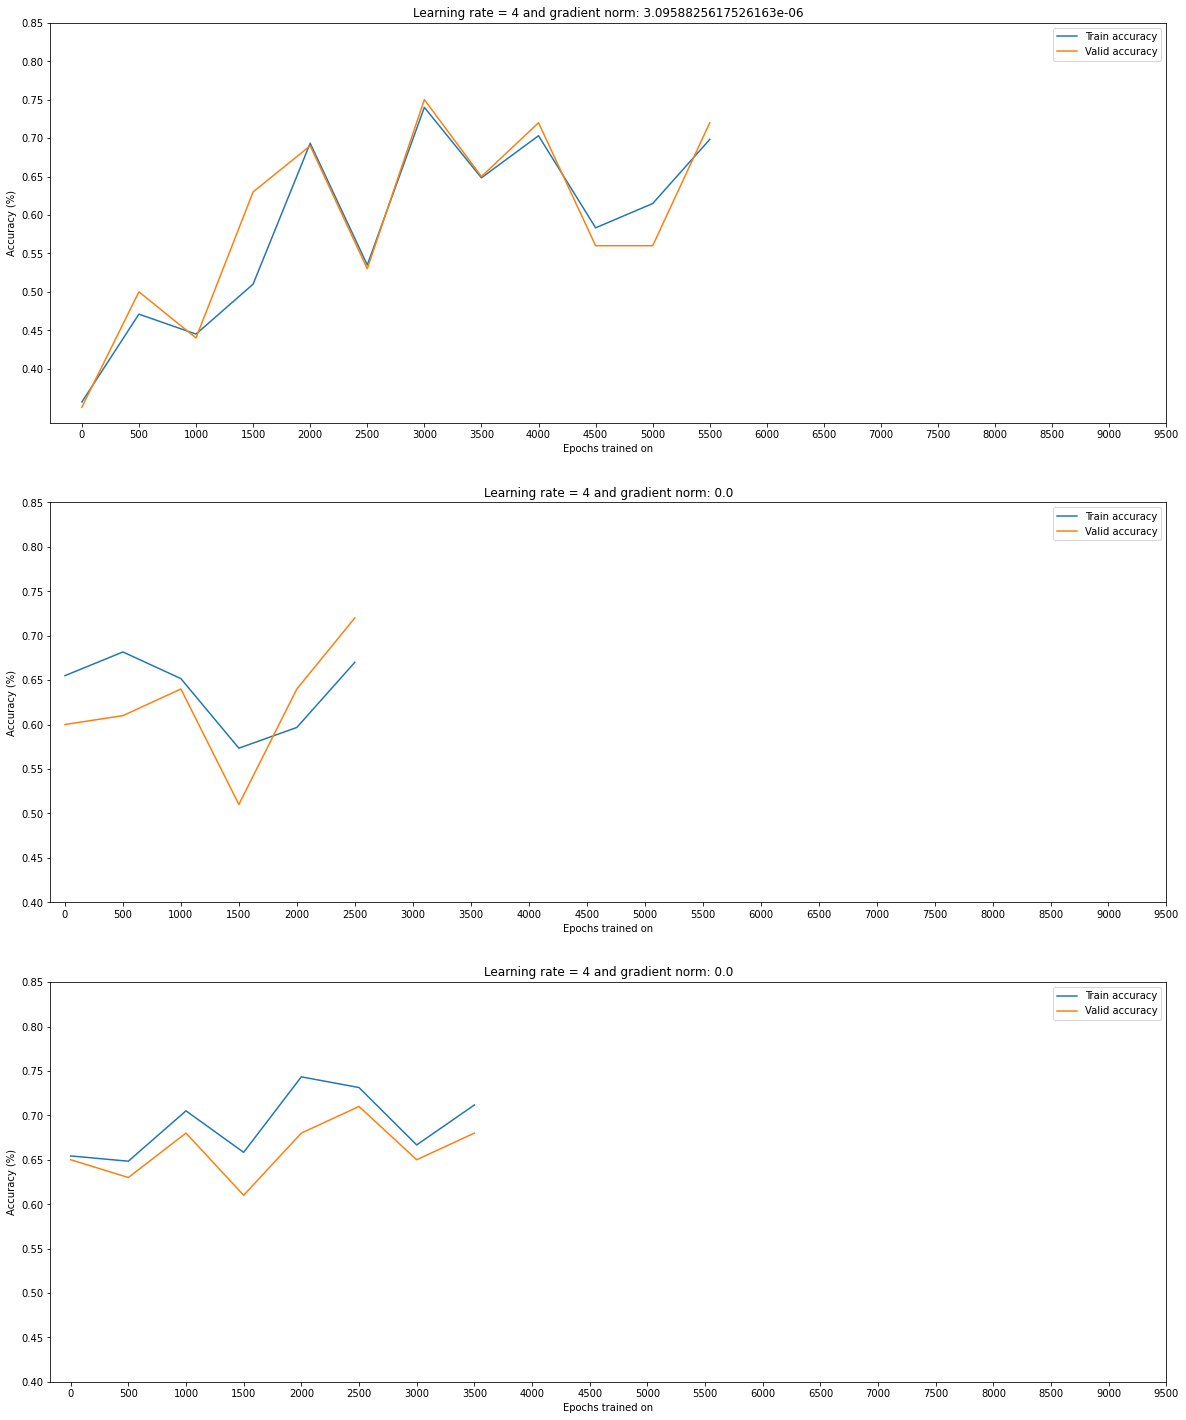

In [ ]:
"""
Second largest batch size: 32

Larger batch sizes, go through more epochs
"""

test_step_size = 500
max_epoch = 10000
iterations = np.arange(0, max_epoch, test_step_size)
lr = 4

momenta = [.9, .95, .99]

max_validation_score = 0
max_iteration_score = 0
max_learning_rate = 0

fig, axs = plt.subplots(len(momenta), 1, figsize=(20,25))

for j in range(0, len(axs)):
  print("\nMomentum: ", momenta[j])
  print("\nLearningRate: ", lr)
  
  clf = LogisticRegression(momentum_coeff=momenta[j] ,max_epochs=max_epoch, learning_rate=lr, verbose=False, test_step_size=test_step_size, batch_size=32)
  clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])

  # This ensure if it converges earlier then the last 0 accuracies are not graphed
  clf.train_accuracies = np.delete(clf.train_accuracies, np.where(clf.train_accuracies == 0))
  clf.valid_accuracies = np.delete(clf.valid_accuracies, np.where(clf.valid_accuracies == 0))
  iterations_val = iterations[:len(clf.valid_accuracies)]
  iterations_train = iterations[:len(clf.train_accuracies)]


  axs[j].plot(iterations_train, clf.train_accuracies, label='Train accuracy')
  axs[j].plot(iterations_val, clf.valid_accuracies, label='Valid accuracy')
  axs[j].set_xticks(np.arange(0, max_epoch, max_epoch // 20))
  axs[j].set_yticks(np.arange(.4, .90, 0.05))
  axs[j].set_title(f'Learning rate = {lr} and gradient norm: {np.linalg.norm(clf.g)}')
  axs[j].legend()
  axs[j].set_xlabel("Epochs trained on")
  axs[j].set_ylabel("Accuracy (%)")

  if np.max(clf.valid_accuracies) > max_validation_score:
    max_validation_score = np.max(clf.valid_accuracies)
    max_iteration_score = np.where(clf.valid_accuracies == max_validation_score)[0][0] * test_step_size
    max_learning_rate = lr

print(f'Max val score: {max_validation_score} with max epoch set to {max_iteration_score} and learning rate {max_learning_rate}\n\n')



Momentum:  0.9

LearningRate:  4

Momentum:  0.95

LearningRate:  4

Momentum:  0.99

LearningRate:  4
Max val score: 0.7 with max epoch set to 2000 and learning rate 4




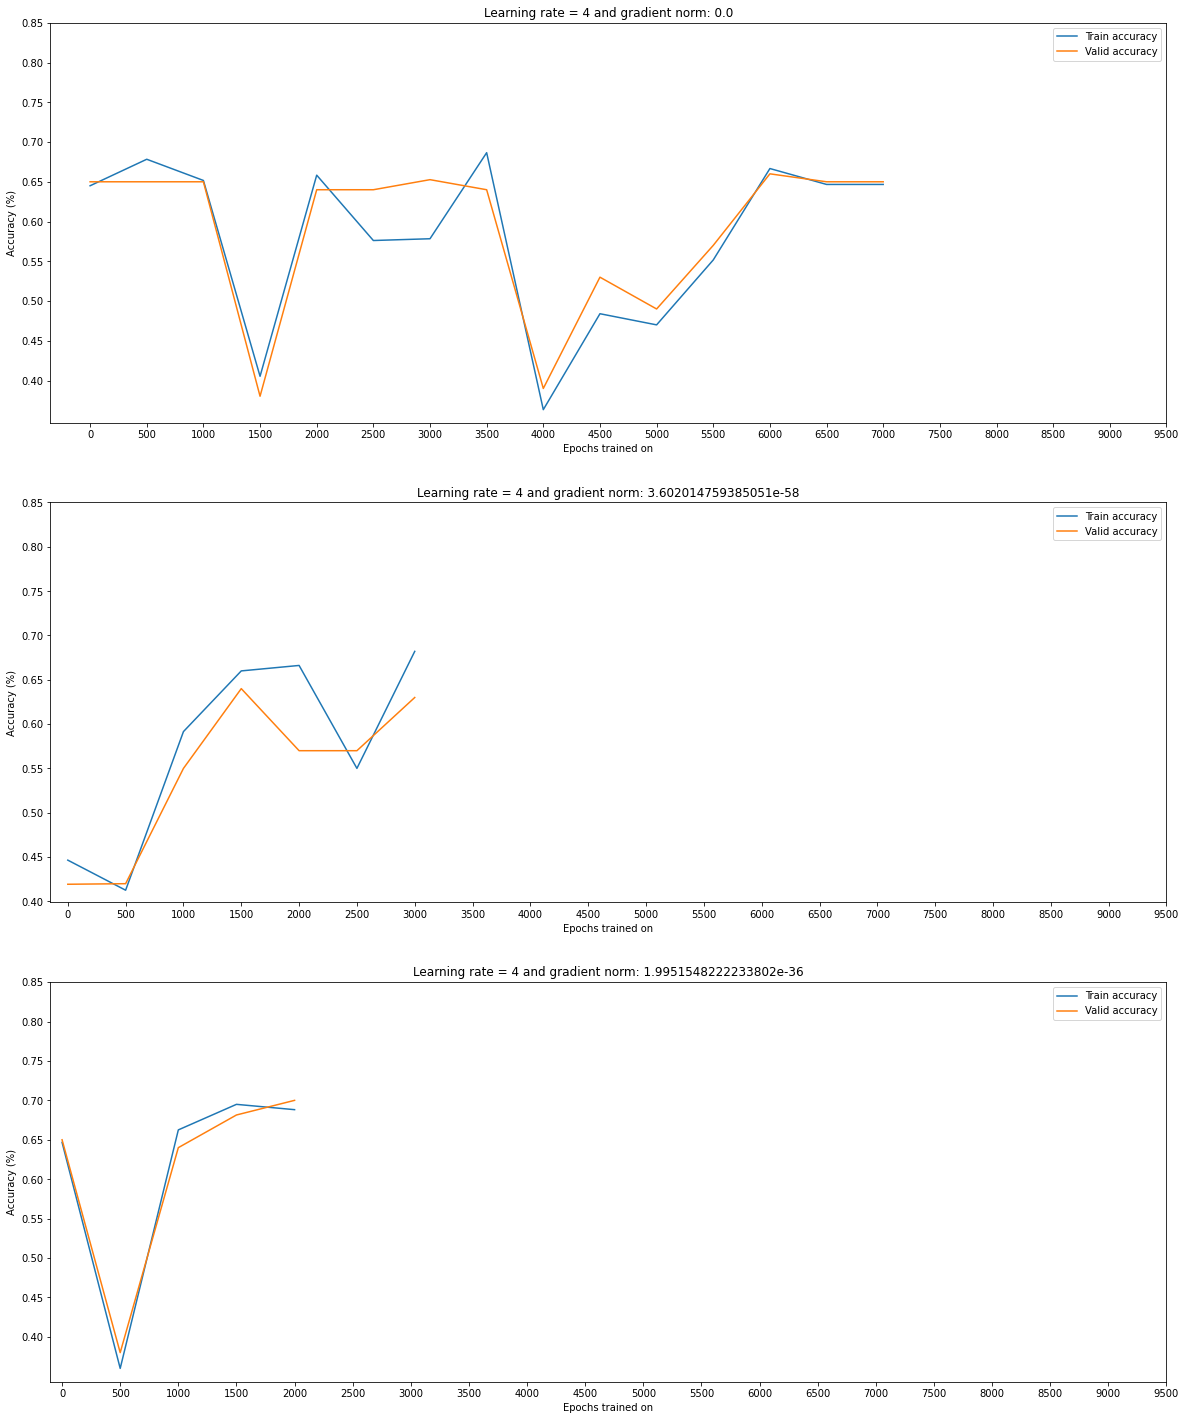

In [ ]:
"""
Largest batch size: 64
"""

test_step_size = 500
max_epoch = 10000
iterations = np.arange(0, max_epoch, test_step_size)
lr = 4

momenta = [.9, .95, .99]

max_validation_score = 0
max_iteration_score = 0
max_learning_rate = 0

fig, axs = plt.subplots(len(momenta), 1, figsize=(20,25))

for j in range(0, len(axs)):
  print("\nMomentum: ", momenta[j])
  print("\nLearningRate: ", lr)
  
  clf = LogisticRegression(momentum_coeff=momenta[j] ,max_epochs=max_epoch, learning_rate=lr, verbose=False, test_step_size=test_step_size, batch_size=64)
  clf.fit(train_df.drop(['Outcome'],axis=1), train_df['Outcome'])

  # This ensure if it converges earlier then the last 0 accuracies are not graphed
  clf.train_accuracies = np.delete(clf.train_accuracies, np.where(clf.train_accuracies == 0))
  clf.valid_accuracies = np.delete(clf.valid_accuracies, np.where(clf.valid_accuracies == 0))
  iterations_val = iterations[:len(clf.valid_accuracies)]
  iterations_train = iterations[:len(clf.train_accuracies)]


  axs[j].plot(iterations_train, clf.train_accuracies, label='Train accuracy')
  axs[j].plot(iterations_val, clf.valid_accuracies, label='Valid accuracy')
  axs[j].set_xticks(np.arange(0, max_epoch, max_epoch // 20))
  axs[j].set_yticks(np.arange(.4, .90, 0.05))
  axs[j].set_title(f'Learning rate = {lr} and gradient norm: {np.linalg.norm(clf.g)}')
  axs[j].legend()
  axs[j].set_xlabel("Epochs trained on")
  axs[j].set_ylabel("Accuracy (%)")

  if np.max(clf.valid_accuracies) > max_validation_score:
    max_validation_score = np.max(clf.valid_accuracies)
    max_iteration_score = np.where(clf.valid_accuracies == max_validation_score)[0][0] * test_step_size
    max_learning_rate = lr

print(f'Max val score: {max_validation_score} with max epoch set to {max_iteration_score} and learning rate {max_learning_rate}\n\n')


# Part 2
___________


In this part, you will be using the fake news dataset. The goal is to detect which articles are generated by a computer, and which ones are written by humans. The dataset has already been split into training, validation, and test. No preprocessing has been applied. A good place to start is the sklearn text data tutorial. For this part, we recommend using the sklearn’s Logistic Regression package as your base model.
Get a basic version working. This includes building a preprocessing pipeline to map raw text to features on which you can train a model. You can go above and beyond, for example, to see if you can achieve more than 80% on the test set.

In [ ]:
"""
Must preprocess the data and then run sklearn logistic model on it.

Build a preprocessing model that will count vectorize the input, potentially use ifdft and then use logistic regression.

We can use validation set to see whih vectorize algorithm (pipeline) is best.
  - options to test: ngrams, removing stop words, using regex to clean text

Then finally get result on test set and hope its more than 80%


We should look into using Adaptive Gradient. He mentioned this in class that
it is good for text classification.
"""

'\nMust preprocess the data and then run sklearn logistic model on it.\n\nBuild a preprocessing model that will count vectorize the input, potentially use ifdft and then use logistic regression.\n\nWe can use validation set to see whih vectorize algorithm (pipeline) is best.\n  - options to test: ngrams, removing stop words, using regex to clean text\n\nThen finally get result on test set and hope its more than 80%\n\n\nWe should look into using Adaptive Gradient. He mentioned this in class that\nit is good for text classification.\n'

In [ ]:
# Import the data
"""
We assume the data is in the same folder as the notebook and is accesible by
the path ./data.csv
"""
fake_news_train = pd.read_csv('fake_news_train.csv')
fake_news_val = pd.read_csv('fake_news_val.csv')
fake_news_test= pd.read_csv('fake_news_test.csv')

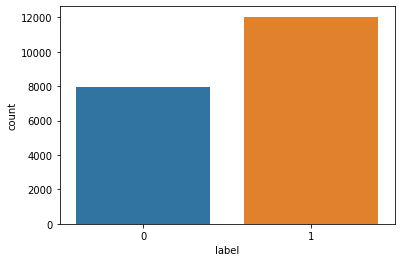

In [ ]:
"""
Look at data to see distribution of values
"""
_ = sns.countplot(x="label", data=fake_news_train)

In [ ]:
"""
Try running the model on a simple classifier
"""
simple_classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
])
simple_classifier.fit(fake_news_train.text, fake_news_train.label)
predicted = simple_classifier.predict(fake_news_val.text)
simple_classifer_score = np.mean(predicted == fake_news_val.label)
print(f"Simple Classifer = {simple_classifer_score}")

Simple Classifer = 0.736


Improve model by experiementing with several things and testing on validation set:
1. Introduce Tfidf vs bag of vectors to ennsure more important and frequent words are given more weightage
2. Clean text using regex and experiment removing stop words
3. Tweak hyperparameters


In [ ]:
"""
Try running the model classifier tfid
"""
tfidf_classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()), # Introduce tfidf to see what effect it has on validation score
    ('clf', LogisticRegression()),
])
tfidf_classifier.fit(fake_news_train.text, fake_news_train.label)
predicted = tfidf_classifier.predict(fake_news_val.text)
tfidf_classifer_score = np.mean(predicted == fake_news_val.label)
print(f"TFIDF Classifer = {tfidf_classifer_score}")

TFIDF Classifer = 0.731


In [ ]:
"""
Try removing unncessary words using regex
"""

# remove non letter chars, whitespaces and convert text to lowercase
def cleaning(word):
    word = word.lower()
    word = re.sub(r"[^a-zA-Z\d\s]", "", word.strip())
    return word

# Cleaning the train set
fake_news_train_cleaned = fake_news_train
fake_news_train_cleaned['text'] = fake_news_train_cleaned['text'].apply(lambda x: cleaning(x))

# check classifier after performing text cleaning
cleaned_classifier = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
])

cleaned_classifier.fit(fake_news_train_cleaned.text, fake_news_train_cleaned.label)
predicted = cleaned_classifier.predict(fake_news_val.text)
cleaned_classifier_score = np.mean(predicted == fake_news_val.label)

print(f"Classifier with regex cleaning = {cleaned_classifier_score}")

Classifier with regex cleaning = 0.7295


In [ ]:
# introdice tfid when training classifier
cleaned_tfid_classifer = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])
cleaned_tfid_classifer.fit(fake_news_train_cleaned.text, fake_news_train_cleaned.label)
predicted = cleaned_tfid_classifer.predict(fake_news_val.text)
cleaned_tfid_classifer_score = np.mean(predicted==fake_news_val.label)

print(f"Regex and Tfid = {cleaned_tfid_classifer_score}")

Regex and Tfid = 0.7065


In [ ]:
"""
Try removing stop words 
"""

cleaned_stop_words_tfidf_classifier = Pipeline([
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=350)),
])
cleaned_stop_words_tfidf_classifier.fit(fake_news_train_cleaned.text, fake_news_train_cleaned.label)
predicted = cleaned_stop_words_tfidf_classifier.predict(fake_news_val.text)
cleaned_stop_words_tfidf_classifier_score = np.mean(predicted == fake_news_val.label)

print(f"Regex, TFIDF, Stop Words = {cleaned_stop_words_tfidf_classifier_score}")

Regex, TFIDF, Stop Words = 0.719


In [ ]:
"""
Final Model with all parameters tuned
"""
## Cleaning the train set and test set
fake_news_train['text'] = fake_news_train['text'].apply(lambda x: cleaning(x))
fake_news_test['text'] = fake_news_test['text'].apply(lambda x: cleaning(x))

def runPipeline(train_text,train_label,test_text,test_label):
    final_classifier = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=350)),
    ])
    final_classifier.fit(train_text, train_label)
    predicted = final_classifier.predict(test_text)
    return np.mean(predicted == test_label)

cleaned_tfidf_ngram = runPipeline(fake_news_train_cleaned.text, fake_news_train_cleaned.label, fake_news_val.text, fake_news_val.label)
final_score = runPipeline(fake_news_train.text, fake_news_train.label, fake_news_test.text, fake_news_test.label)

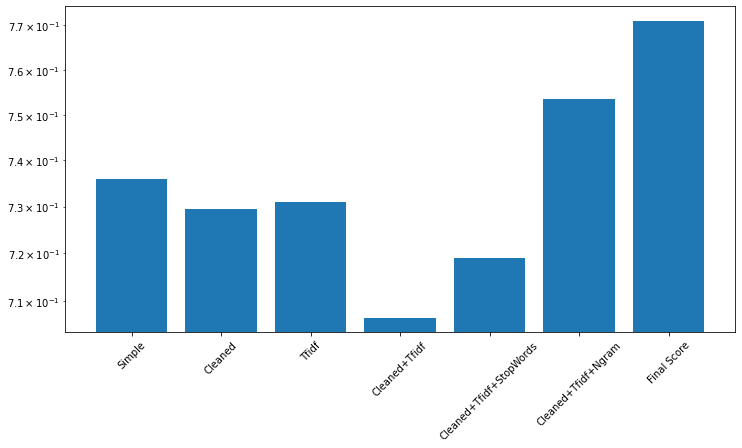

In [ ]:
import matplotlib.pyplot as plt

x = ['Simple', 'Cleaned', 'Tfidf', 'Cleaned+Tfidf', 'Cleaned+Tfidf+StopWords',
     'Cleaned+Tfidf+Ngram','Final Score']
y = [simple_classifer_score, cleaned_classifier_score, tfidf_classifer_score, 
      cleaned_tfid_classifer_score, cleaned_stop_words_tfidf_classifier_score, 
      cleaned_tfidf_ngram, final_score]

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(np.arange(len(x)),y, log=1)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x, rotation = 45, zorder=100)
fig.show()